In [ ]:
# Cell 1 ── Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import seaborn as sns

# For reproducibility
TRAIN_RANDOM_SEED = 42
TEST_RANDOM_SEED = 51
palette = sns.color_palette("colorblind")
sns.set_theme(style="whitegrid", palette="colorblind")

In [ ]:
# Cell 2 ── Define parameter grid and container for results
noise_levels   = [0.1, 0.3, 0.5, 0.8]
training_sizes = [100, 200, 400, 800, 1600, 2400,3000]
test_size      = 1000

results = []


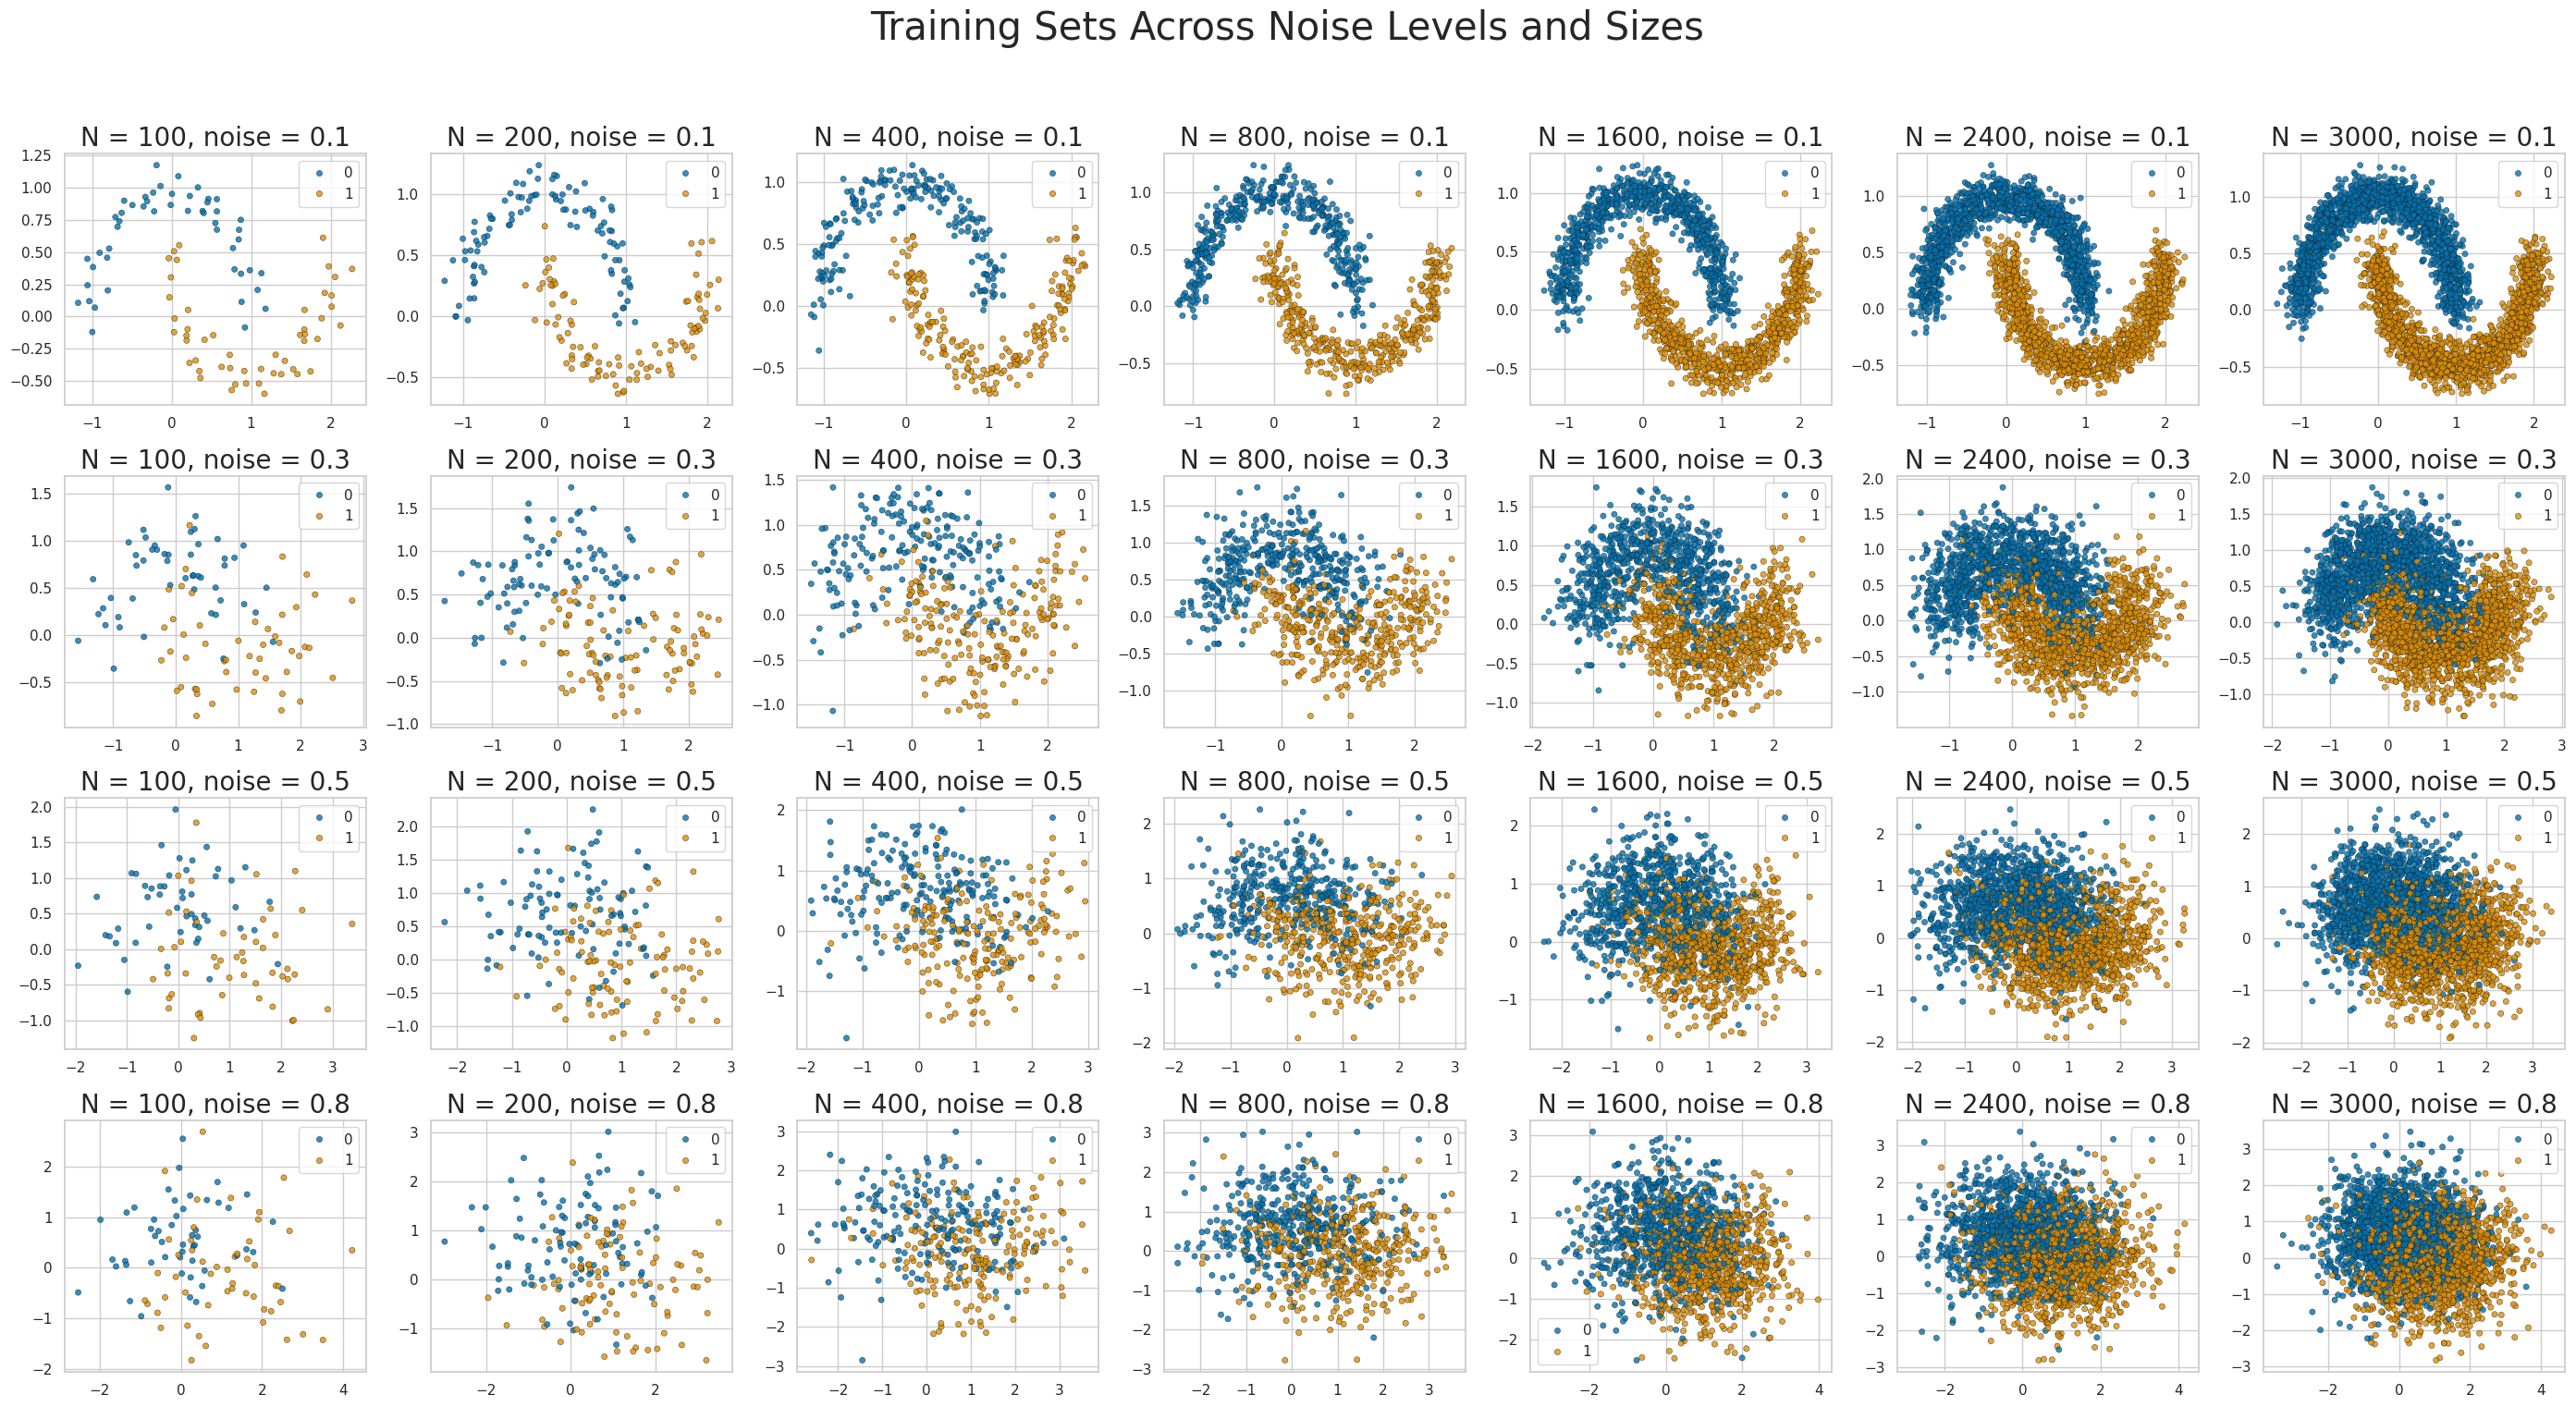

In [ ]:
#Visualize Training Sets Across Noise Levels
n_rows = len(noise_levels)
n_cols = len(training_sizes)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
    sharex=False,
    sharey=False
)

for i, noise in enumerate(noise_levels):
    for j, N in enumerate(training_sizes):
        ax = axes[i, j]
        X, y = make_moons(
            n_samples=N,
            noise=noise,
            random_state=TRAIN_RANDOM_SEED
        )
        sns.scatterplot(
            ax=ax,
            x=X[:, 0],
            y=X[:, 1],
            hue=y,
            palette="colorblind",
            s=20,
            edgecolor='k',
            alpha=0.8,
            legend=True
        )
        # combined title per subplot
        ax.set_title(f'N = {N}, noise = {noise}', fontsize=20)

fig.suptitle('Training Sets Across Noise Levels and Sizes', fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# save to PDF
fig.savefig('all_training_sets_grid.pdf', format='pdf', bbox_inches='tight')
plt.show()

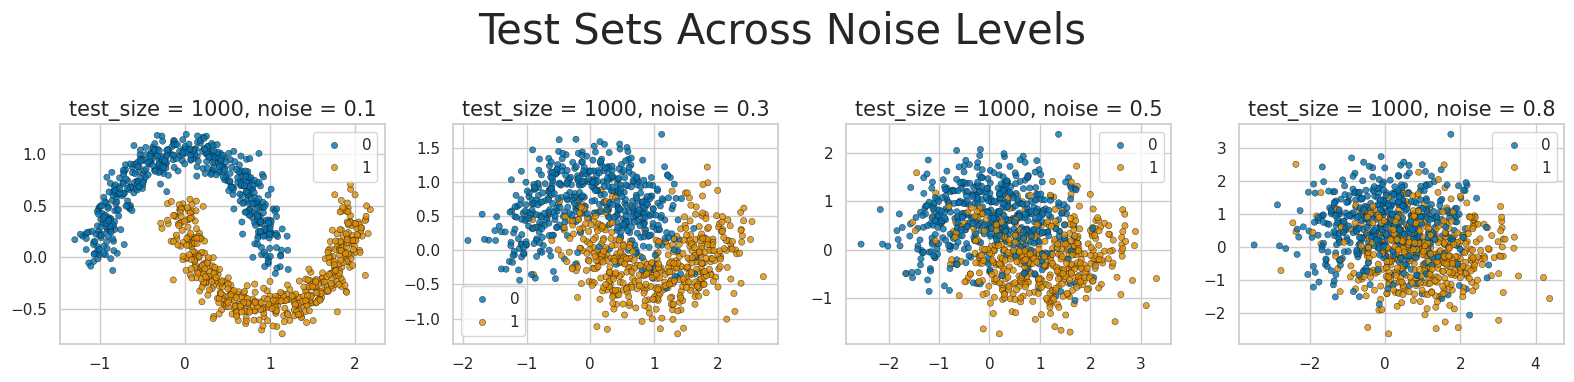

In [ ]:
n_rows = 1
n_cols = len(noise_levels)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
    sharex=False,
    sharey=False
)

# flatten axes for easy iteration
axes = axes.flatten()

for ax, noise in zip(axes, noise_levels):
    # generate test moons for this noise
    X_test, y_test = make_moons(
        n_samples=test_size,
        noise=noise,
        random_state=TEST_RANDOM_SEED
    )
    # scatter plot
    sns.scatterplot(
        ax=ax,
        x=X_test[:, 0],
        y=X_test[:, 1],
        hue=y_test,
        palette="colorblind",
        s=20,
        edgecolor='k',
        alpha=0.8,
        legend=True
    )
    # combined title per subplot
    ax.set_title(f'test_size = {test_size}, noise = {noise}', fontsize=15)

fig.suptitle('Test Sets Across Noise Levels', fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# save all‑in‑one PDF
fig.savefig('all_test_sets_grid.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Cell 3 ── Generate datasets, train KNN, record accuracies and gaps
for noise in noise_levels:
    # fixed test set for this noise level
    X_test, y_test = make_moons(n_samples=test_size,
                                noise=noise,
                                random_state=TEST_RANDOM_SEED)
    for N in training_sizes:
        # training set of size N
        X_train, y_train = make_moons(n_samples=N,
                                      noise=noise,
                                      random_state=TRAIN_RANDOM_SEED)
        # KNN classifier (default n_neighbors=5)
        clf = KNeighborsClassifier()
        clf.fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        test_acc  = clf.score(X_test,  y_test)
        gap       = train_acc - test_acc

        results.append({
            'noise':     noise,
            'N':         N,
            'train_acc': train_acc,
            'test_acc':  test_acc,
            'gap':       gap
        })

# assemble into DataFrame
df = pd.DataFrame(results)
# df.head()


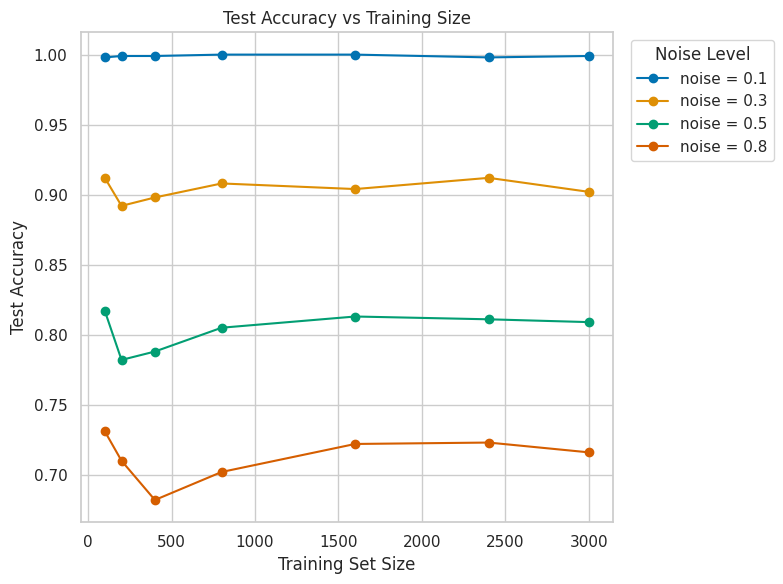

In [ ]:
# Cell 4 ── Plot: Test Accuracy vs Training Size (and Save)
plt.figure(figsize=(8, 6))
for noise in noise_levels:
    subset = df[df['noise'] == noise].sort_values('N')
    plt.plot(
        subset['N'],
        subset['test_acc'],
        marker='o',
        linestyle='-',
        linewidth=1.5,
        label=f'noise = {noise}'
    )

plt.title('Test Accuracy vs Training Size')
plt.xlabel('Training Set Size')
plt.ylabel('Test Accuracy')
plt.legend(title='Noise Level', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.subplots_adjust(right=0.8)
plt.grid(True)
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('test_accuracy_vs_training_size.pdf', format='pdf', bbox_inches='tight')

plt.show()

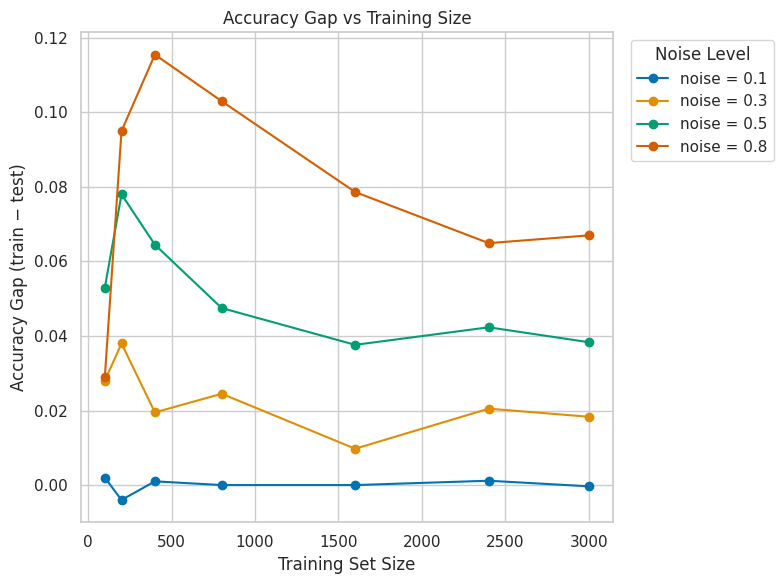

In [ ]:
# Cell 5 ── Plot: Accuracy Gap vs. Training Size (one figure per noise level)
plt.figure(figsize=(8, 6))
for noise in noise_levels:
    subset = df[df['noise'] == noise].sort_values('N')
    plt.plot(
        subset['N'],
        subset['gap'],
        marker='o',
        linestyle='-',
        linewidth=1.5,
        label=f'noise = {noise}'
    )

plt.title('Accuracy Gap vs Training Size')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Gap (train − test)')
plt.legend(title='Noise Level', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.subplots_adjust(right=0.8)
plt.grid(True)
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('accuracy_gap_vs_training_size.pdf', format='pdf', bbox_inches='tight')

plt.show()


In [ ]:
# Cell 6 ── Fit linear regression N = f(noise, test_acc)
X_reg = df[['noise', 'test_acc']]
y_reg = df['N']

reg = LinearRegression()
reg.fit(X_reg, y_reg)

print(f'R² score: {reg.score(X_reg, y_reg):.3f}')


R² score: 0.031


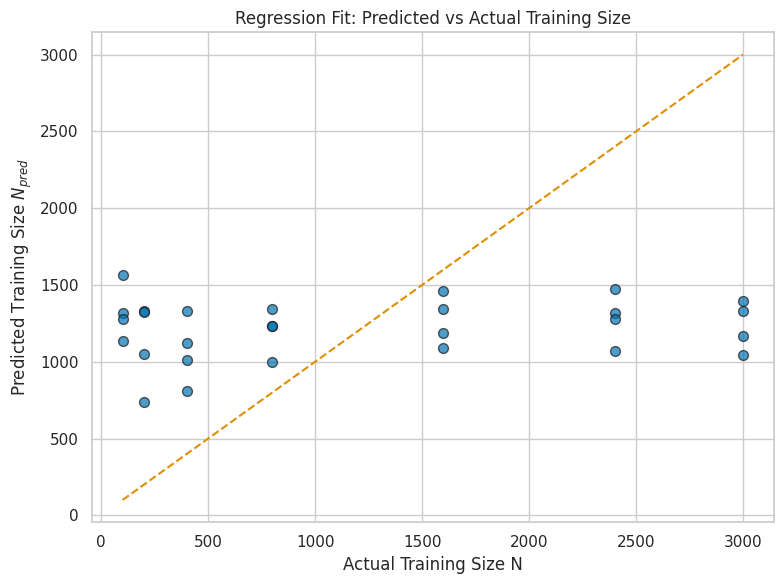

In [ ]:
# Cell 7 ── Visualize fit: Predicted vs. Actual training size
scatter_color = palette[0]
line_color    = palette[1]

# assume df, reg, and X_reg are already defined
df['N_pred'] = reg.predict(X_reg)

plt.figure(figsize=(8, 6))

# scatter actual vs. predicted
plt.scatter(
    df['N'],
    df['N_pred'],
    color=scatter_color,
    edgecolor='k',
    s=50,
    alpha=0.7
)

# 45° reference line
min_N, max_N = df['N'].min(), df['N'].max()
plt.plot(
    [min_N, max_N],
    [min_N, max_N],
    linestyle='--',       # only linestyle here
    color=line_color,     # explicit color
    linewidth=1.5          # no marker keyword at all
)

plt.title('Regression Fit: Predicted vs Actual Training Size')
plt.xlabel('Actual Training Size N')
plt.ylabel('Predicted Training Size $N_{pred}$')
plt.grid(True)
plt.tight_layout()

# save as PDF
plt.savefig('regression_fit_predicted_vs_actual.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Prepare the features and target correctly
X_reg_poly = df[['noise', 'test_acc']].values
Y_reg_poly = df['N'].values

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_reg_poly)

# Fit the model
reg_poly = LinearRegression()
reg_poly.fit(X_poly, Y_reg_poly)

print(f'R² score: {reg_poly.score(X_poly, Y_reg_poly):.3f}')


R² score: 0.088


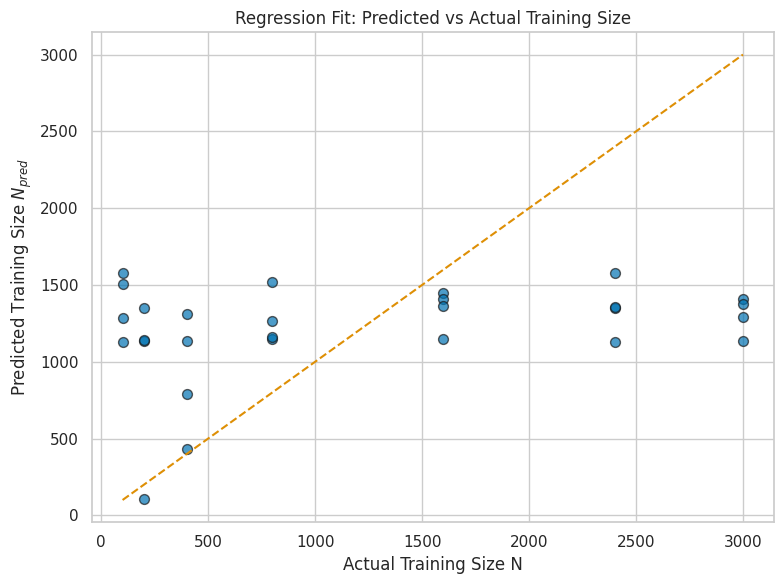

In [ ]:
# Cell 7 ── Visualize fit: Predicted vs. Actual training size
df['N_pred'] = reg_poly.predict(X_poly)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(
    df['N'],
    df['N_pred'],
    color=scatter_color,
    edgecolor='k',
    s=50,
    alpha=0.7,
    marker='o'
)

# 45° reference line
min_N, max_N = df['N'].min(), df['N'].max()
plt.plot(
    [min_N, max_N],
    [min_N, max_N],
    linestyle='--',
    color=line_color,
    linewidth=1.5
)

plt.title('Regression Fit: Predicted vs Actual Training Size')
plt.xlabel('Actual Training Size N')
plt.ylabel('Predicted Training Size $N_{pred}$')
plt.grid(True)
plt.tight_layout()

# save as PDF
plt.savefig('regression_fit_poly_predicted_vs_actual.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
X_reg = df[['noise', 'test_acc']]
y_reg = df['N']
tree = DecisionTreeRegressor()
tree.fit(X_reg, y_reg)
print(f'R² score: {tree.score(X_reg, y_reg):.3f}')

R² score: 0.666


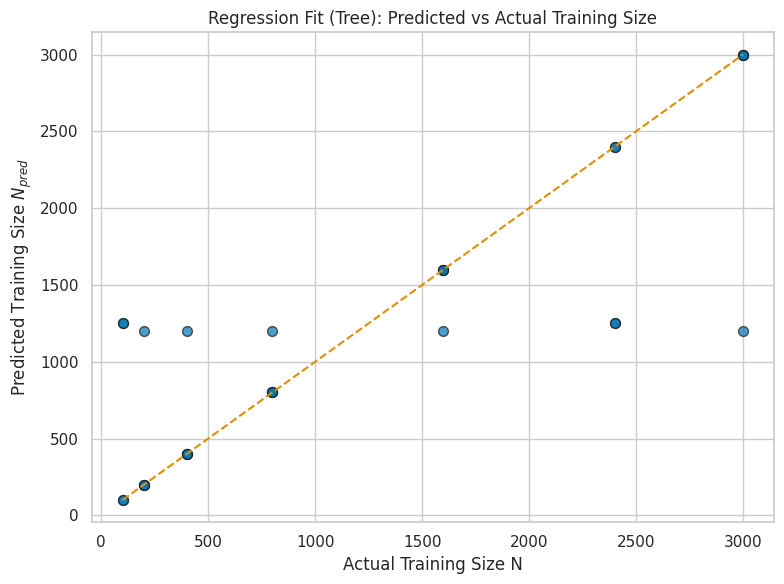

In [ ]:
# Cell 7 ── Visualize fit: Predicted vs. Actual training size
# predict with decision tree
df['N_pred'] = tree.predict(X_reg)

# create the plot
plt.figure(figsize=(8, 6))
plt.scatter(
    df['N'],
    df['N_pred'],
    color=scatter_color,
    edgecolor='k',
    s=50,
    alpha=0.7,
    marker='o'
)

# 45° reference line
min_N, max_N = df['N'].min(), df['N'].max()
plt.plot(
    [min_N, max_N],
    [min_N, max_N],
    linestyle='--',
    color=line_color,
    linewidth=1.5
)

plt.title('Regression Fit (Tree): Predicted vs Actual Training Size')
plt.xlabel('Actual Training Size N')
plt.ylabel('Predicted Training Size $N_{pred}$')
plt.grid(True)
plt.tight_layout()

# save as PDF
plt.savefig('tree_regression_fit_predicted_vs_actual.pdf', format='pdf', bbox_inches='tight')
plt.show()